## Gradients

$\pi$


$\pi$

cs231n.github.io/neural-networks-3/


In [214]:
from math import sin, cos
import matplotlib.pyplot as plt
import numpy as np
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 6.4, 4.8
mpl.rcParams['figure.dpi'] = 100
   #: 6.4, 4.8   # figure size in inches
#

In [215]:
@np.vectorize
def any_function(x):
    return (x)**2 + 3*sin(x) - 4*cos((x)**2)

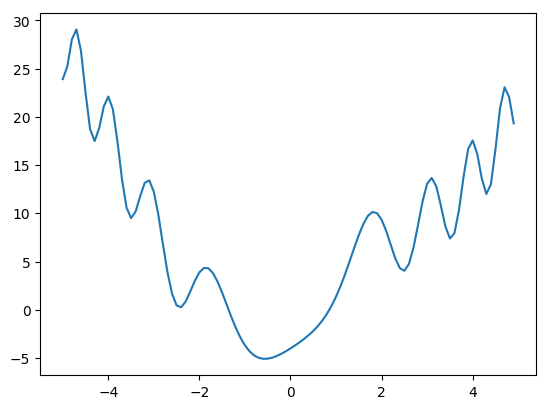

In [216]:
x = np.arange(-5, 5, 0.1)
y = any_function(x)

curveFigure = plt.figure()
plt.plot(x,y, figure = curveFigure)
plt.show()

Next, we need to find the deviation. A very simple and popular method is using [symmetric difference](https://en.wikipedia.org/wiki/Numerical_differentiation).

In [217]:
@np.vectorize
def numerical_derivative(x, f, h = 0.001):
    return (f(x+h) - f(x-h))/(2.0*h)

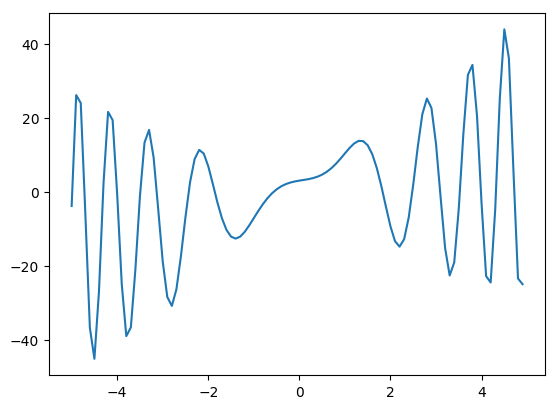

In [218]:
ytick = numerical_derivative(x, any_function)

plt.plot(x,ytick)
plt.show()

Now, we look for an $x$ for which $f'(x) = 0$. Seems like a difficult function to optimize since there are many values where this is the case.

For starters we can choose one point randomly, say $x = 3$, and start our gradient descend - basically we move $x$ to the negative gradient, only scaled by some 'rate' = $\mu$, i.e. $x_{\mathtt{new}} = x_{\mathtt{old}} - \mu * f'(x_{\mathtt{old}})$.

Furthermore, since $f'(x_1)$ is basically the slope of the tangent at $(x_1,y_1)$ we simply can draw it by using the equation $y = f'(x_1)\cdot(x - x_1) + y_1$

In [219]:
@np.vectorize
def tangent(x, x_p, any_function):
    y_p = any_function(x_p)
    m = numerical_derivative(x_p, any_function)
    y = m*(x - x_p) + y_p
    return y

#tangent([min(x), max(x)], xn, any_function)

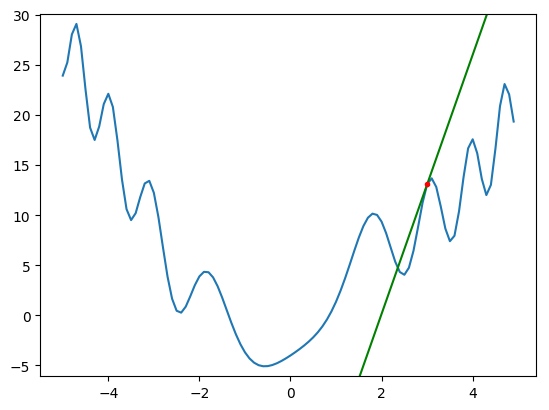

In [220]:
xn = 3
mu = 0.2

x_range = [min(x), max(x)]
y_range = tangent(x_range, xn, any_function)

plt.plot(x,y)
plt.plot(x_range, y_range, '-g')
plt.plot(xn, any_function(xn), '.r')
plt.ylim(min(y)-1, max(y)+1)
plt.show()

xn: 0.415843, f(xn) = -2.555534, f'(xn) = 4.148432
mu = 0.200000


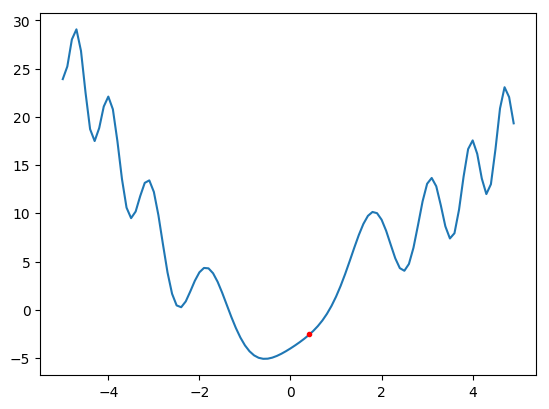

In [221]:
#mu = 0.9*mu
xnew = xn - mu * numerical_derivative(xn, any_function)
xn = xnew

print 'xn: %f, f(xn) = %f, f\'(xn) = %f' % (xn, any_function(xn), numerical_derivative(xn, any_function))
print 'mu = %f' % (mu)
plt.plot(x,y)
plt.plot(xn, any_function(xn), '.r')
plt.show()
# TODO: animate!

In [222]:
class NumericalDerivative(object):
    
    def __init__(self, f, h = 0.0001):
        self.h = h
        self.f = f
        
    def __call__(self, x):
        f, h = self.f, self.h
        return (f(x+h) - f(x-h))/(2.0*h)
    
class GradientMethod(object):
    
    def __init__(self, x0, targetFunction, derivative = None, **kwargs):
        self.targetFunction = targetFunction
        if derivative is None:
            self.derivative = NumericalDerivative(targetFunction)
        
        if 'mu' in kwargs:
            self.mu0 = kwargs['mu']
        else:
            self.mu0 = 0.1
        
        if 'maxiter' in kwargs:
            self.maxiter = kwargs['maxiter']
        else:
            self.maxiter = 1000
        self.x0 = x0
        ## step initialization
        self._current_iteration = 0 
        self._xnew = x0
        self._ynew = self.targetFunction(self._xnew)
        self._mu = self.mu0

    def reset(self):
        self._current_iteration = 0
        self._xnew = self.x0
        self._ynew = self.targetFunction(self._xnew)
        self._mu = self.mu0
    
    def next(self):
        """Compute xnew and ynew.
        
        Terminate if y and ynew are close to each other or we reached the upper limit of iterations.
        """
        ftick_x = self.derivative(self._xnew)
        xn = self._xnew - self._mu * ftick_x
        yn = self.targetFunction(xn)
        if np.isclose(yn, self._ynew, rtol=1e-08, atol=1e-12) or (self._current_iteration > self.maxiter):
            raise StopIteration
        else:
            self._ynew = yn
            self._xnew = xn
            self._current_iteration += 1
            return self._xnew, self._ynew
    
    def tangent(self, xlim):
        x = np.asarray(xlim)
        return self.derivative(self._xnew)*(x - self._xnew) + self._ynew
    

class GMIterator(object):
    
    def __init__(self, gm):
        self.gm = gm   

    def __iter__(self):
        self.gm.reset()
        return self.gm
    
    
class GMAnimator(GMIterator):
    
    def __init__(self, ax, *args):
        GMIterator.__init__(self, *args)
        self._ax = ax
        self._currentstep, = self._ax.plot([], [], '.r')
        self.tangent, = self._ax.plot([], [], '-g')
        
    def reset(self):
        self._currentstep.set_data([], [])
        self.tangent.set_data([], [])
        self.gm.reset()
        return self._currentstep, 
            
    def __call__(self, i):
        try:
            self.gm.next()
            xlim = self._ax.get_xlim()
            ylim = self.gm.tangent(xlim)
            #print xlim, ylim
            self.tangent.set_data(xlim, ylim)
            self._currentstep.set_data(self.gm._xnew, self.gm._ynew)
            #print self.gm._xnew, self.gm._ynew
        except Exception as e:
            print e
        
        return self._currentstep, self.tangent



gm = GradientMethod(4, any_function)
for k in GMIterator(gm):
    print k

(4.3173836316339163, array(11.958489654788604))
(4.288522475806019, array(12.069385623533561))
(5.0715606256246346, array(19.583924121304587))
(1.7012988737721244, array(9.747337804447412))
(1.0670794006073478, array(2.0907895602984126))
(-0.06633004319534308, array(-4.194405857535973))
(-0.35217086052741564, array(-4.880059772897143))
(-0.5284718318501227, array(-5.0783741640530025))
(-0.56530566999324705, array(-5.0849331154224275))
(-0.56349538491718221, array(-5.08494793031829))
(-0.56366746861469608, array(-5.084948064647164))


In [223]:
gm.reset()
print gm.tangent(xlim=[-50, 51])
print tangent([-50, 51], gm._xnew, gm.targetFunction)

[ 188.94739152 -131.61007643]
[ 188.94375876 -131.60691459]


In [225]:
fig, ax = plt.subplots()
ax.plot(x,y)
#ax.set_xlim(-5, 5)
#ax.set_ylim(min(y)-1, max(y)+1)
ax.grid(True)
gma = GMAnimator(ax, gm)


anim = FuncAnimation(fig, gma, frames = 10, init_func=gma.reset,
                     interval=550, blit=True)
HTML(anim.to_html5_video())
rc('animation', html='html5')
anim


4

This example shows very nicely that altought we are close at finding the minimum we still have trouble to converge. This is due to the fixed learning rate. Hence, it is sensible to reduce the learning rate with time, e.g. by using exponetial decay $\mu = \mu_0*e^{-kt}$ ([see for others](http://cs231n.github.io/neural-networks-3/#anneal)).

In [22]:
def decay_exp(mu_0, t, k):
    return mu_0 * np.exp(-k*t)


def optimize_simple(f, x, mu, mudecay = decay_exp, k = 1, maxiter = 1000, eps = 0.001):
    y = f(x)
    i = 1
    yn = np.inf
    
    xhist = [x]
    yhist = [y]
    gradhist = [np.inf]
    
    mu_act = mudecay(mu, 0, k)
    while (not np.isclose(y, yn, rtol=1e-08, atol=1e-12)) and (i < maxiter):
        y = yn
        ftick_x = numerical_derivative(x, f)
        x = x - mu_act * ftick_x
        yn = f(x)
        
        xhist.append(x)
        yhist.append(yn)
        gradhist.append(ftick_x)
        
        mu_act = mudecay(mu, i, k)
        i += 1
    
    
   
    return xhist, yhist, gradhist
    

22


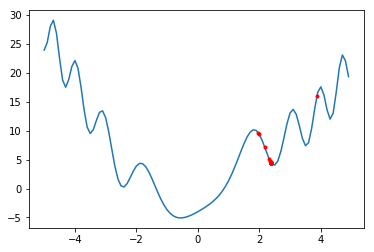

In [34]:
plt.plot(x,y)
xhist, yhist, gradhist = optimize_simple(any_function, 2, 0.2)
print len(xhist)
plt.plot(xhist, yhist, '.r')
    
plt.show()

In [44]:
#def a_fun(x):
#    return x**2 + 2# + 3*(x*np.abs(sin(x)))

#any_function = np.vectorize(a_fun, otypes=[np.float])

@interact(x_in = (-4, 4, 0.1), mu = (0.01, 1, 0.01), k = (0.01, 5, 0.01))
def interactive_optim(x_in, mu, k):
    xhist, yhist, gradhist = optimize_simple(any_function, x_in, mu, k=k)
    xx = np.arange(min(xhist), max(xhist), 0.01)
    yy = any_function(xx)
    print len(xhist)
    print 'Solution at %f (%f) is %f (%f)' % (xhist.pop(), xhist.pop(), yhist.pop(), yhist.pop())
    plt.plot(xx,yy)
    plt.plot(xhist, yhist, '.r')   
    plt.show()


## Linear Regression Example

A simple Linear Regression based on Least Squares is usually solved by  $\mathbf{w} = (\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{X}\hat{y}$ - i.e. it requires (relatively) expensive operation like matrix multiplication and matrix inverse. Sometimes the data is large and using linear algebra is simply not possible.

Gradiens come to help! By using Gradient Descent on the Squared Loss $E = \frac{1}{2}\sum\limits_{\mathbf{x}_i \in \mathbf{X}} (f(\mathbf{x}_i) - y)^2$ we may be able to find hopefully the right weights. 

The derivative of $E$ with respect to a 'weight' $w_i$ in $f(\cdot)$ is $ E'_{w_i} = \frac{dE}{dw_i}$


## Notes

An alternative approach is to comptue the gradient using [Automatic Differentiation](https://pypi.python.org/pypi/ad)